In [1]:
import numpy as np
from scipy.stats import ortho_group
from scipy.linalg import fractional_matrix_power
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
#Data generation

In [2]:
np.random.seed(100)

m, d = 70, 70

# A0 = np.random.normal(mu, var, size=(m, d))
# A = A0 / norm(A0, 2)

D = np.zeros((m, m))
for i in range(0, len(D)):
    D[i, i] = 1 / ((i + 1) ** 4)

U = ortho_group.rvs(dim=m)
A0 = U @ D @ U.T
A = A0 / norm(A0, 2)

W = A.T @ A

# training set of input/outputs

tau = 0.25  # noise level
def training_set(n, tau, alpha):
    r = np.random.rand(1) ** (1 / d)
    u_tr = np.zeros((n, d))
    z_train = np.zeros((n, d))
    for i in range(n):
        u_tr[i] = np.random.randn(d)
        r = np.random.rand(1) ** (1 / d)
        z_train[i] = (r * u_tr[i]) / norm(u_tr[i], ord=2)

    x0_train = fractional_matrix_power(W, alpha) @ z_train.T
    x_train = np.zeros((d, n))
    for i in range(n):
        x_train[:, i] = x0_train[:, i] / norm(x0_train[:, i], ord=2)

    eps_train = np.zeros((m, n))
    for i in range(n):
        eps_train[:, i] = np.random.normal(0, tau, m)

    y_train = A @ x_train + eps_train

    return x_train, y_train

alph_lan = 3
alph_tik = 3
# Full training set
x_tik, y_tik = training_set(10000, tau, alph_tik)

x_lan, y_lan = training_set(10000, tau, alph_lan)

N_test = 10
x_ttik, y_ttik = training_set(N_test, tau, alph_tik)
x_tlan, y_tlan = training_set(N_test, tau, alph_lan)

In [108]:
# Functions

# Tikhonov filter
def tikh(y, la):
    return np.linalg.solve(W + la * np.identity(d), A.T @ y)


# Landweber filter:
def landweber(y, t):
    landw = np.zeros(d)
    iterates = np.zeros((t, d))
    Y = A.T @ y
    for i in range(t):
        landw -= .2 * (W @ landw - Y)
        iterates[i] = landw
    return landw, iterates


# Errors for the whole training set
def train_tik(la): #This will only be useful to compute lambda*
    ftiklist = np.array([tikh(y, la) for y in y_tik.T])
    norms = np.linalg.norm(ftiklist, axis=1, ord=2)
    ftiklist[norms > 1] /= norms[norms > 1, np.newaxis]
    sumvec = norm(ftiklist - x_tik.T, axis=1) ** 2
    return np.average(sumvec)


def train_landw(max_t):
    errors = np.zeros((len(x_lan.T), max_t))
    for i in range(len(x_lan.T)):
        _, all_iterates = landweber(y_lan.T[i], max_t)
        norms = norm(all_iterates, axis=1, ord=2)
        rows = np.where(norms > 1)[0]
        all_iterates[rows] /= norms[rows][:, np.newaxis]
        errors[i] = np.linalg.norm(all_iterates - x_lan.T[i], axis=1) ** 2
    return np.mean(errors, axis=0)

# Errors depending on n
def train_tikn(n, la):
    x_tr, y_tr = training_set(n, tau, alph_tik)
    ftiklist = np.array([tikh(y, la) for y in y_tr.T])
    norms = np.linalg.norm(ftiklist, axis=1, ord=2)
    ftiklist[norms > 1] /= norms[norms > 1, np.newaxis]
    sumvec = norm(ftiklist - x_tr.T, axis=1) ** 2
    return np.average(sumvec)


def train_landwn(n, max_t):
    x_tr, y_tr = training_set(n, tau, alph_lan)
    errors = np.zeros((n, max_t))
    for i in range(n):
        _, all_iterates = landweber(y_tr.T[i], max_t)
        norms = norm(all_iterates, axis=1, ord=2)
        rows = np.where(norms > 1)[0]
        all_iterates[rows] /= norms[rows][:, np.newaxis]
        errors[i] = np.linalg.norm(all_iterates - x_tr.T[i], axis=1) ** 2
    return np.mean(errors, axis=0)


# Functions for varynoise, tstartau
def tik_tau(tau, la, alph):
    n_tr = 1000
    x_tr, y_tr = training_set(n_tr, tau, alph)
    ftiklist = np.array([tikh(y, la) for y in y_tr.T])
    norms = np.linalg.norm(ftiklist, axis=1, ord=2)
    ftiklist[norms > 1] /= norms[norms > 1, np.newaxis]
    sumvec = norm(ftiklist - x_tr.T, axis=1) ** 2
    return np.average(sumvec)


def best_lam(tau, la, alph):  # la is a vector here
    tik_err = np.array([tik_tau(tau, l, alph) for l in la])
    return la[np.argmin(tik_err)], tik_err.min()


def landw_tau(tau, max_t, alph):
    n_tr = 1000
    x_tr, y_tr = training_set(n_tr, tau, alph)
    errors = np.zeros((n_tr, max_t))
    for i in range(n_tr):
        _, all_iterates = landweber(y_tr.T[i], max_t)
        norms = norm(all_iterates, axis=1, ord=2)
        rows = np.where(norms > 1)
        all_iterates[rows] /= norms[rows][:, np.newaxis]
        errors[i] = np.linalg.norm(all_iterates - x_tr.T[i], axis=1) ** 2
    return np.mean(errors, axis=0)


def best_t(tau, t, alph):  # t is a vector here
    landw_err_full = landw_tau(tau, t[-1], alph)
    landw_err = np.zeros(len(t))
    for i in range(len(t)):
        landw_err[i] =landw_err_full[t[i]-1]
    return t[np.argmin(landw_err)], landw_err.min()


#Test functions

def test_tik(la): #This will only be useful to compute lambda*
    ftiklist = np.array([tikh(y, la) for y in y_ttik.T])
    norms = np.linalg.norm(ftiklist, axis=1, ord=2)
    ftiklist[norms > 1] /= norms[norms > 1, np.newaxis]
    sumvec = norm(ftiklist - x_ttik.T, axis=1) ** 2
    return np.mean(sumvec)


def test_landw(max_t):
    errors = np.zeros((N_test, max_t))
    for i in range(N_test):
        _, all_iterates = landweber(y_tlan.T[i], max_t)
        norms = np.linalg.norm(all_iterates, axis=1, ord=2)
        rows = np.where(norms > 1)[0]
        all_iterates[rows] /= norms[rows][:, np.newaxis]
        errors[i] = np.linalg.norm(all_iterates - x_tlan.T[i], axis=1) ** 2
    return np.min(np.mean(errors, axis=0))

def noise_rate (tau, alph):
    frac = (- 4 * alph) / (2 * alph + 1)
    return tau ** (frac)

In [ ]:
# figure 1

np.random.seed(100)
n_it = 30

lamb_EmR = np.logspace(-4, 2, num=50)

tik_err = np.zeros((len(lamb_EmR), n_it))
for i in range(len(lamb_EmR)):
    for j in range(n_it):
        tik_err[i, j] = train_tikn(100, lamb_EmR[i])

meantik = np.mean(tik_err, axis=1)
lowertik = np.quantile(tik_err, 0.05, axis=1)
uppertik = np.quantile(tik_err, 0.95, axis=1)

t_emR = np.logspace(- np.log10(250.5), 0, num=50)
for i in range(len(t_emR)):
    t_emR[i]= int(1 / t_emR[i])
t_emR=t_emR[::-1].astype(int)

land_err = np.zeros((n_it, t_emR[-1]))
for i in range(n_it):
    land_err[i] = train_landwn(100, t_emR[-1])

landw_err = np.zeros((n_it, len(t_emR)))

for i in range(n_it):
    landw_err[i] = land_err[i, t_emR - 1]

meanlandw = np.mean(landw_err, axis=0)
lowerlandw = np.quantile(landw_err, 0.05, axis=0)
upperlandw = np.quantile(landw_err, 0.95, axis=0)

In [ ]:
# Plots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=300)
# fig.suptitle('Filters')
ax1.semilogx(lamb_EmR, meantik, label='Tikhonov')
ax1.fill_between(lamb_EmR, lowertik, uppertik, alpha=0.2)
ax1.scatter(lamb_EmR, meantik, color='red', s=50) 
ax1.set_xlabel(r'$\lambda$', fontsize=25)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.legend(fontsize=20)

ax2.semilogx(t_emR, meanlandw, label='Landweber')
ax2.fill_between(t_emR, lowerlandw, upperlandw, alpha=0.2)
ax2.scatter(t_emR, meanlandw, color='red', s=50)
ax2.set_xlabel('k', fontsize=25)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.legend(fontsize=20)

supylabel = fig.supylabel(r'$\widehat{L}(X_\lambda)$', fontsize=25)
supylabel.set_position((0, 0.5)) 
plt.tight_layout()


plt.savefig("./filters.pdf", bbox_inches='tight')
plt.show(block=False)

In [135]:
# figure 2

#Tikhonov
lamb = np.linspace(1e-5, 0.5, num=100) #I have to change this every time i change tauv
taut = np.logspace(-5, -1, num=50)

Lstartik05 = np.array([best_lam(r, lamb, .5)[1] for r in taut])
Lstartik07 = np.array([best_lam(r, lamb, .7)[1] for r in taut])
Lstartik09 = np.array([best_lam(r, lamb, .9)[1] for r in taut])

ftik05 = Lstartik05 * noise_rate(taut, .5)
ftik07 = Lstartik07 * noise_rate(taut, .7)
ftik09 = Lstartik09 * noise_rate(taut, .9)

In [146]:
# Landweber

t_emR = np.linspace(1/150, 0.51, 100) #this is good even for t^-8
for i in range(len(t_emR)):
    t_emR[i]= int(1 / t_emR[i])
    
t = t_emR[::-1].astype(int) 

taul = np.logspace(-4, -2, num=50)

Lstarland4 = np.array([best_t(r, t, 4)[1] for r in (taul ** 2)])
Lstarland5 = np.array([best_t(r, t, 5)[1] for r in (taul ** 2)])
Lstarland6 = np.array([best_t(r, t, 6)[1] for r in (taul ** 2)])

fland4 = Lstarland4 * noise_rate(taul**2, 4)
fland5 = Lstarland5 * noise_rate(taul**2, 5)
fland6 = Lstarland6 * noise_rate(taul**2, 6)

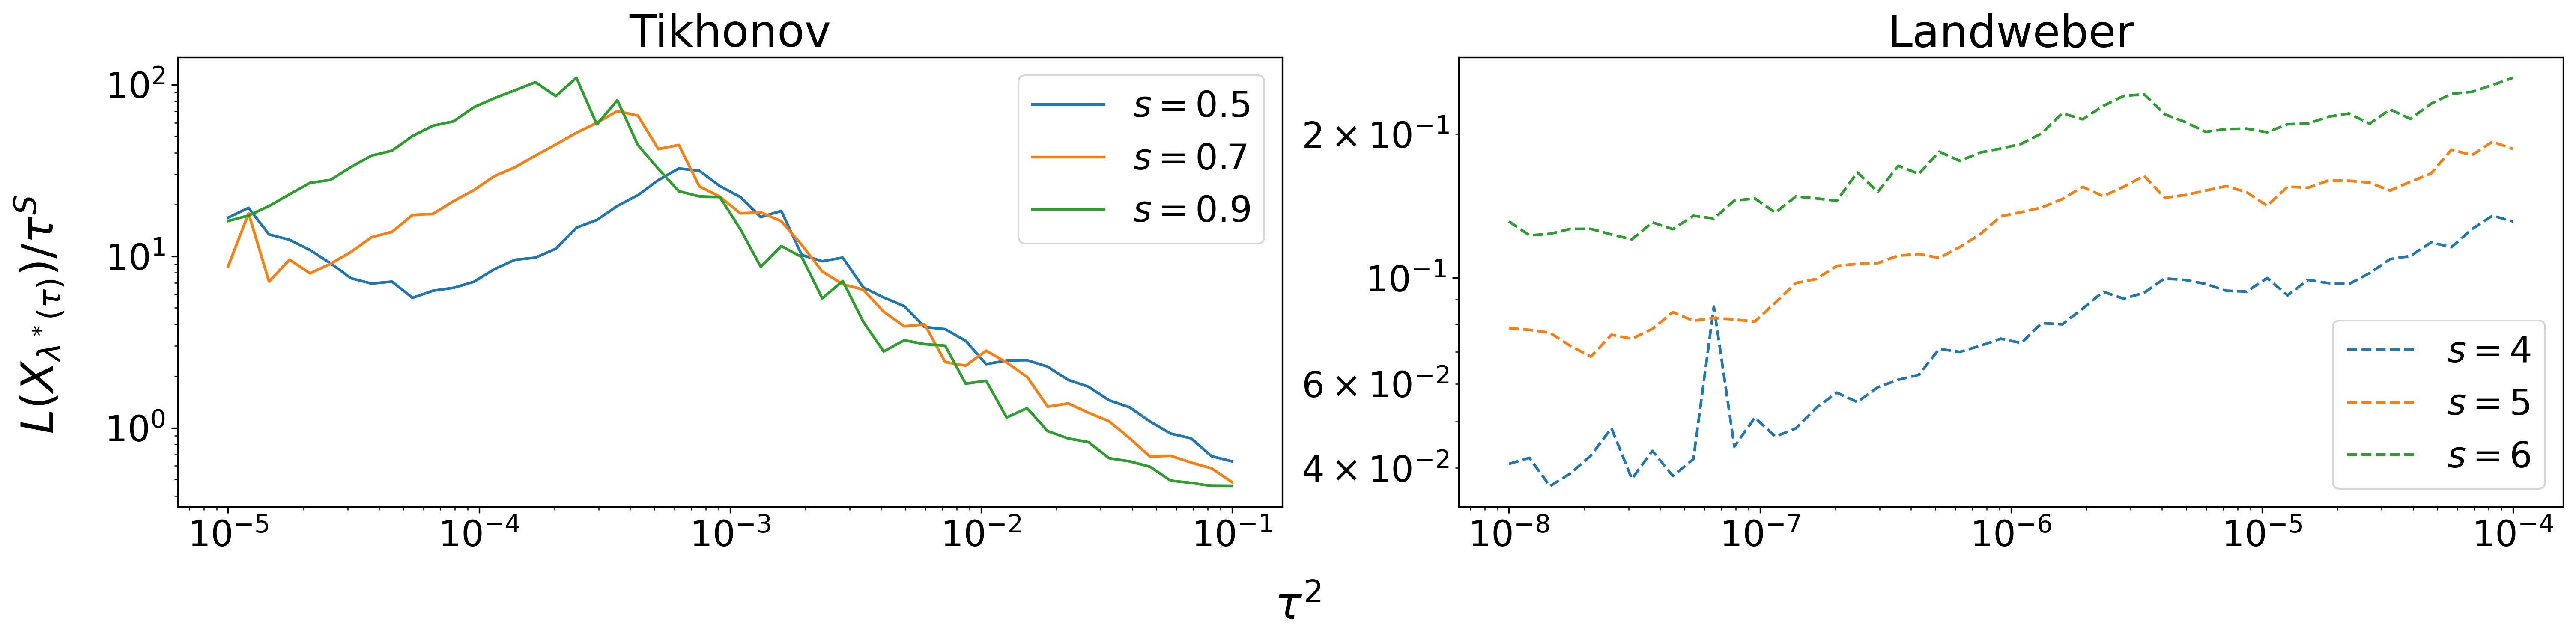

In [148]:
# Joint plot

plt.close('all')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=300)


ax1.plot(taut, ftik05, linestyle='-', label=r'$s=0.5$')
ax1.plot(taut, ftik07, linestyle='-', label=r'$s=0.7$')
ax1.plot(taut, ftik09, linestyle='-', label=r'$s=0.9$')
ax1.legend(fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=20)
ax1.set_title("Tikhonov", fontsize=25)

ax2.plot(taul**2, fland4, linestyle='--', label=r'$s=4$')
ax2.plot(taul**2, fland5, linestyle='--', label=r'$s=5$')
ax2.plot(taul**2, fland6, linestyle='--', label=r'$s=6$')
ax2.legend(fontsize=20)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=20)
ax2.set_title("Landweber", fontsize=25)

supylabel = fig.supylabel(r'$L(X_{\lambda^*(\tau)})/\tau^S$', fontsize=25)
supylabel.set_position((0, 0.5)) 
fig.supxlabel(r"$\tau^2$", fontsize=25)

plt.tight_layout()
plt.savefig("./ftaudiv.pdf", bbox_inches='tight')
plt.show(block='False')

In [ ]:
# Figure 3

np.random.seed(100)
n_it = 30

lamb = np.logspace(-4, 0, num=50)

t_emR = np.logspace(- np.log10(100.5), 0, num=50) 
for i in range(len(t_emR)):
    t_emR[i]= int(1 / t_emR[i])
    
t_emR = t_emR[::-1].astype(int) #both lamb and t are correct for these noise levels

tauvec = np.logspace(-3, 0, num=50) ** 2

if 'matrixlam.npy' not in os.listdir():
    lamb_matrix = np.zeros((len(tauvec), n_it))
    t_matrix = np.zeros((len(tauvec), n_it))
    for i in range(len(tauvec)):
        for j in range(n_it):
            lamb_matrix[i, j] = best_lam(tauvec[i], lamb, alph_tik)[0]
            t_matrix[i, j] = best_t(tauvec[i], t_emR, alph_lan)[0]
    np.save('matrixt.npy', t_matrix)
    np.save('matrixlam.npy', lamb_matrix)
else:
    lamb_matrix = np.load('matrixlam.npy')
    t_matrix = np.load('matrixt.npy')


meantik = np.mean(lamb_matrix, axis=1)
lowertik = np.quantile(lamb_matrix, 0.05, axis=1)
uppertik = np.quantile(lamb_matrix, 0.95, axis=1)

meanland = np.mean(t_matrix, axis=1)
lowerland = np.quantile(t_matrix, 0.05, axis=1)
upperland = np.quantile(t_matrix, 0.95, axis=1)


In [ ]:
# Plots

plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=100)
# fig.suptitle("Behaviour of $\lambda$ varying the noise level")

ax1.plot(tauvec, meantik, '-', label='Tikhonov')
ax1.fill_between(tauvec, lowertik, uppertik, alpha=0.2)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(r'$\widehat{\lambda}(\tau)$', fontsize=25)
ax1.legend(fontsize=20)

ax2.plot(tauvec, meanland, linestyle='--', label='Landweber')
ax2.fill_between(tauvec, lowerland, upperland, alpha=0.2)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\widehat{k}(\tau)$', fontsize=25)
ax2.legend(fontsize=20)

fig.supxlabel(r'$\tau^2$', fontsize=25)
plt.tight_layout(pad=2, w_pad=1.2, h_pad=0.5)

plt.savefig("./varynoise.pdf", bbox_inches='tight')
plt.show(block=False)


In [ ]:
# Comparison against QO

# Cross-validation functions

# Tikhonov
def get_lambda_hat(lamb):
    tik_err = np.array([train_tikn(100, l) for l in lamb])
    return lamb[np.argmin(tik_err)]


# Landweber
def get_t_hat(t):
    errors = train_landwn(100, len(t))
    return t[np.argmin(errors)]


#QO functions
def qopt_tikhonov(y, lamda):
    tiks = np.array([tikh(y, l) for l in lamda])
    tikdif = np.array([norm(tiks[i+1] - tiks[i]) for i in range(len(tiks) - 1)])
    pos = np.argmin(tikdif)
    return lamda[pos]


def qopt_landweber(y, t):
    landwdif = np.zeros(len(t))
    iterates = landweber(y, len(t))[1]
    for i in range(len(landwdif)):
        landwdif[i] = norm(iterates[i] - landweber(A @ iterates[i], i+1)[0])
    pos = np.argmin(landwdif)
    return t[pos]

# Parameters

N = 100
lamb = np.logspace(-5, 1, N)

t_emR = np.logspace(- np.log10(500.5), 0, num=50)
for i in range(len(t_emR)):
    t_emR[i]= int(1 / t_emR[i])
    
t = t_emR[::-1].astype(int)

n_it = 30

In [ ]:
#Best parameters for each case and errors

lamb_hat_opt = np.array([get_lambda_hat(lamb) for i in range(n_it)])
t_hat_opt = np.array([get_t_hat(t) for i in range(n_it)])
t_hat_opt = t_hat_opt.astype(int)

crosstik = np.array([test_tik(l) for l in lamb_hat_opt])
crossland = np.array([test_landw(l) for l in t_hat_opt])


qopt_tik = np.array([qopt_tikhonov(y, lamb) for y in y_ttik.T])
qopt_land = np.array([qopt_landweber(y, lamb) for y in y_tlan.T])

f_qopt_tik = np.zeros((N_test, d))
f_qopt_land = np.zeros((N_test, d))
for i in range(N_test):
    f_qopt_tik[i] = tikh(y_ttik.T[i], qopt_tik[i])
    f_qopt_land[i] = landweber(y_tlan.T[i], int(qopt_land[i]))[0]

err_qopt_tik = np.mean(norm(f_qopt_tik - x_ttik.T, axis=1) ** 2, axis=0)
err_qopt_land = np.mean(norm(f_qopt_land - x_tlan.T, axis=1) ** 2, axis=0)

meantikqopt = np.mean(crosstik - err_qopt_tik)
vartikqopt = np.std(crosstik - err_qopt_tik)
meanlandqopt = np.mean(crossland - err_qopt_land)
varlandqopt = np.std(crossland - err_qopt_land)


In [ ]:
print('Means and stds:')
print('Tikhonov mean:', meantikqopt)
print('Tikhonov std:', vartikqopt)
print('Landweber mean:', meanlandqopt)
print('Landweber std:', varlandqopt)

In [ ]:
# Figure 4

# Tikhonov
def get_lambda_star(lamb):
    tik_err = np.array([train_tik(l) for l in lamb])
    lambda_star = lamb[np.argmin(tik_err)]
    return lambda_star, tik_err.min()

# Tikhonov
def cvlambda(n, lamb):
    tik_err = np.array([train_tikn(n, l) for l in lamb])
    return tik_err.min(), lamb[np.argmin(tik_err)]

def get_lambda_hat(L_lambda_star, lamb, N_vec, n_it):
    Deltan = np.zeros((len(N_vec), n_it))
    lamb_hatn = np.zeros((len(N_vec), n_it))
    for i in range(len(N_vec)):
        for j in range(n_it):
            lamb_hatn[i, j] = cvlambda(N_vec[i], lamb)[1]
            Deltan[i, j] = np.abs(L_lambda_star - cvlambda(N_vec[i], lamb)[0])
    return Deltan

#Landweber
def get_t_star(t):
    landw_err_full = train_landw(t[-1])
    landw_err = np.zeros(len(t))
    for i in range(len(t)):
        landw_err[i] =landw_err_full[t[i]-1]
    return t[np.argmin(landw_err)], landw_err.min()


def cvt(n, t):
    errors_full = train_landwn(n, t[-1])
    errors = np.zeros(len(t))
    for i in range(len(t)):
        errors[i] =errors_full[t[i]-1]
    return errors.min(), t[np.argmin(errors)]


def get_t_hat(L_t_star, t, N_vec, n_it):
    Deltan = np.zeros((len(N_vec), n_it))
    t_hatn = np.zeros((len(N_vec), n_it))
    for i in range(len(N_vec)):
        for j in range(n_it):
            t_hatn[i, j] = cvt(N_vec[i], t)[1]
            Deltan[i, j] = np.abs(L_t_star - cvt(N_vec[i], t)[0])
    return Deltan


In [ ]:
np.random.seed(100)
n_it = 30

lamb = np.logspace(-4, 2, num=50)

t_emR = np.logspace(- np.log10(250.5), 0, num=50)
for i in range(len(t_emR)):
    t_emR[i]= int(1 / t_emR[i])
    
t1 = t_emR[::-1].astype(int)

N_vec = np.arange(10, 160, 10)

if 'Deltatik.npy' not in os.listdir():
    # Tikhonov
    _, L_lambda_star = get_lambda_star(lamb)
    deltatik = get_lambda_hat(L_lambda_star, lamb, N_vec, n_it)
    Deltatik = np.zeros(np.shape(deltatik))
    for i in range(len(N_vec)):
        Deltatik[i] = deltatik[i] * np.sqrt(N_vec[i]) # We multiply it by the rate
    
    # Landweber
    _, L_t_star = get_t_star(t1)
    deltalan = get_t_hat(L_t_star, t1, N_vec, n_it)
    Deltalan = np.zeros(np.shape(deltalan))
    for i in range(len(N_vec)):
        Deltalan[i] = deltalan[i] * np.sqrt(N_vec[i]) # We multiply it by the rate
    
    np.save('Deltatik.npy', Deltatik)
    np.save('Deltalan.npy', Deltalan)
else:
    Deltatik = np.load('Deltatik.npy')
    Deltalan = np.load('Deltalan.npy')


dftik = pd.DataFrame(Deltatik)
meanDeltik = dftik.mean(axis='columns') 
lowertik = np.quantile(Deltatik, 0.05, axis=1) 
uppertik = np.quantile(Deltatik, 0.95, axis=1) 

dfland = pd.DataFrame(Deltalan)
meanDelland = dfland.mean(axis='columns')
lowerland = np.quantile(Deltalan, 0.05, axis=1) 
upperland = np.quantile(Deltalan, 0.95, axis=1)

In [ ]:
# Plots

plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=100)

ax1.plot(N_vec, meanDeltik, '-', label='Tikhonov')
ax1.scatter(N_vec, meanDeltik, color='red', s=50) 
ax1.fill_between(N_vec, lowertik, uppertik, alpha=0.2)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.legend(fontsize=20)

ax2.plot(N_vec, meanDelland, linestyle='--', label='Landweber')
ax2.scatter(N_vec, meanDelland, color='red', s=50) 
ax2.fill_between(N_vec, lowerland, upperland, alpha=0.2)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.legend(fontsize=20)

fig.supxlabel(r'$n$', fontsize=25)
fig.supylabel(r'$\Delta(n)\sqrt{n}$', fontsize=25)
plt.tight_layout(pad=2, w_pad=1.2, h_pad=0.8)
plt.savefig("./ER_paper.pdf", bbox_inches='tight')  # This shud go before show
plt.show(block=False)